## Modeling strong gravitational lenses with Lenstronomy, using as input ML estimates

Notebook originally developed by Gillian Cartwright [Original notebook](https://github.com/gilliancartwright/Image-Segmentation/blob/main/Model.ipynb)

In [1]:


script = False
cluster = False



In [2]:
import random
import time
import corner
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.visualization import make_lupton_rgb
import pandas as pd
plt.style.use(astropy_mpl_style)
# plt.style.use('dark_background')

from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import plot_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.LensModel.lens_model import LensModel


In [3]:
def seed_everything(seed):
    """
    @author Jimena Gonzalez
    Seeds basic parameters for reproductibility of results
    Args:
        * seed {int}: number of the seed
    Returns: void
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


In [4]:
def get_data(filename):
    hdu_list = fits.open(filename)
    original = hdu_list[1].data
    segmented = hdu_list[2].data
    data = pd.DataFrame(hdu_list[3].data)
    
    
    data = data.sort_values(by='EXP_SCORE', axis=0, ascending=False)
    original = original[data.index]
    segmented = segmented[data.index]
    data = data.reset_index(drop=True)
    
    hdu_list.close()
    return original, segmented, data

In [5]:
def plot_rgb_image(image, coadd_id, title=None):
    """
    Plot 3 channel rgb image
    Args: 
        * image {(3, pix, pix) numpy array}
        * title {str} (optional)
    Returns: void
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    ax.imshow(rgb, aspect='equal', origin='lower')
    ax.axis('off')

    if title is not None:
        ax.set_title(title)

    if script:
        plt.savefig(f"{coadd_id}_rgb.pdf", dpi=300, bbox_inches="tight")
    else:
        plt.savefig(f"modeling_data/{coadd_id}_rgb.pdf", dpi=300, bbox_inches="tight")
        plt.show()
    plt.close()
        


In [6]:
def save_rgb_image(image, image_name, title=None):
    """
    Plot 3 channel rgb image
    Args: 
        * image {(3, pix, pix) numpy array}
        * title {str} (optional)
    Returns: void
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    ax.imshow(rgb, aspect='equal', origin='lower')
    ax.axis('off')

    if title is not None:
        ax.set_title(title)
    
    plt.savefig(image_name + '_RGB.png', format='png')


In [7]:
def plot_multiple(images, coadd_id, titles=None):
    """
    Plot multiple images in single row with optional titles
    Args:
        * images {list}: list of 2d numpy arrays of images
        * titles {list} (optional): list of strings, must be same length as images
    """
    fig, ax = plt.subplots(figsize=(3*len(images), len(images)), ncols=len(images))
    
    for i, img in enumerate(images):
        ax[i].imshow(img, aspect='equal', origin='lower', cmap='magma')
        ax[i].axis('off')

        if titles is not None:
            ax[i].set_title(titles[i])

    if script:
        plt.savefig(f"{coadd_id}_multiple_masks.pdf", dpi=300, bbox_inches="tight")
    else:
        plt.savefig(f"modeling_data/{coadd_id}_multiple_masks.pdf", dpi=300, bbox_inches="tight")
        plt.show()
    plt.close()     

In [8]:
def plot_mask(image, complete):
    fig, ax = plt.subplots(figsize=(20, 5), ncols=2) # 6
    
    ax[0].set_title('original image')
    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    ax[0].imshow(rgb, aspect='equal', origin='lower')
    ax[0].axis('off')
    
    ax[1].set_title('complete')
    ax[1].imshow(complete[0, :, :], interpolation='nearest', cmap='magma', origin='lower')  # source
    ax[1].imshow(complete[1, :, :], alpha=0.5, interpolation='bilinear', cmap='spring', origin='lower')  # lens
    ax[1].imshow(complete[2, :, :], alpha=0.5, interpolation='bilinear', cmap='cool', origin='lower') # noise
    ax[1].axis('off')
    
    # ax[2].set_title('source')
    # ax[3].set_title('lens')
    # ax[4].set_title('noise')
    # ax[5].set_title('background')
    
    # for i in range(4):
    #     ax[i+2].imshow(complete[i, :, :], cmap='magma', origin='lower')
    #     ax[i+2].axis('off')
    
    if not script:
        plt.tight_layout()
        plt.show()
        plt.close()


In [9]:
def get_stats(values):
    """
    Get mean, stdev, min, and max from list of values
    Args: 
        * values {list}
    Returns: mean, stdev, min, max
    """
    return np.mean(values), np.std(values), np.min(values), np.max(values)


In [10]:
def normalize(flat):
    """
    Normalize a 1D numpy array between 0-100
    Args:
        * flat {numpy 1D array}: array to be normalized
    Returns: normalized 1D numpy array
    """
    flat.astype(np.float64)
    MIN = np.min(flat)
    MAX = np.max(flat)
    for i in range(len(flat)):
        flat[i] = (flat[i]-MIN)/(MAX-MIN)

    return flat

In [11]:
# set filepath
if cluster:
    filename = 'b_segmented.fits' #str(sys.argv[1])
else:
    filepath = '/Users/jimenagonzalez/research/DSPL/Hybrid_SL_Modeling/Segmentation/ML/data/'
    filename = filepath + 'b_segmented.fits'

# get data
print(filename)
original, segmented, data = get_data(filename)
coadd_list = data['COADD_OBJECT_ID'].values.tolist()

# show example if in notebook
# if not script:
#     for i in range(len(coadd_list)):
#index = coadd_list.index(1287909989)

#plot_mask(original[index], segmented[index])

# Camera Specifications
EXP_TIME = 90.  # exposure time 
NUM_PIX = 45  # pixels per axis
DELTA_PIX = 0.2637  # pixel size in arcsec

# set seeds
seed_everything(9)

/Users/jimenagonzalez/research/DSPL/Hybrid_SL_Modeling/Segmentation/ML/data/b_segmented.fits


In [12]:
def get_rms(image, complete_mask, testing=False):
    """
    Randomly select 1/4 of all background pixels to find background RMS
    Args: 
        * image {(3, pix, pix) numpy array}: original rgb image
        * complete_mask {(3, pix, pix) numpy array}:
    Returns: g, r, i RMS values
    """
    # select pixels farthest to the edge
    # get coordinates of the background region from mask
    background_coords = []
    for i in range(len(complete_mask[3, :, 0])):
        for j in range(len(complete_mask[3, 0, :])):
            if complete_mask[3, i, j] > 0.75 and np.sqrt((i-45/2)**2 + (j-45/2)**2) >= 20:  # TESTING
                background_coords.append([i, j])

    g_vals = []
    r_vals = []
    i_vals = []

    if testing:
        where=np.zeros((45, 45))
    # randomly select 1/4 of background for sampling
    for coords in random.sample(background_coords, int(len(background_coords)/4)):
        if testing:
            where[coords[0], coords[1]] = 1

        g_vals.append(image[0, coords[0], coords[1]])
        r_vals.append(image[1, coords[0], coords[1]])
        i_vals.append(image[2, coords[0], coords[1]])

    if testing:
        plt.imshow(where, cmap='gist_gray', origin='lower')
        plt.show()
        plt.close()
    
    rms_list = []  # rms values will be saved here and returned
    for flat_image in [g_vals, r_vals, i_vals]:
        squared_vals = []
        for i in range(len(flat_image)):
            squared_vals.append(flat_image[i]**2)

        rms_list.append(np.sqrt(np.mean(squared_vals)))

    return rms_list[0], rms_list[1], rms_list[2]


In [13]:
def get_lens_coords(lens_mask):
    """
    Get the coordinates of the brightest lens pixels from segmentation output
    Args:
        * lens_mask {2d numpy array}
    Returns: list of lens ra and dec coords
    """
    # get coordinates of the lens region from mask in ra and dec
    lens_ra = []
    lens_dec = []
    for i in range(NUM_PIX):
        for j in range(NUM_PIX):
            if lens_mask[i][j] >= 0.5:  # select only brightest pixels
                ra = (i - (NUM_PIX)/2) * DELTA_PIX
                dec = (j - (NUM_PIX)/2) * DELTA_PIX
                lens_ra.append(ra)
                lens_dec.append(dec)

    return lens_ra, lens_dec

In [14]:
def approx_theta_E(center_ra, center_dec, source_mask):
    """
    Approximate the einstein radius and error from source light
    Input: 
        * center_ra {float}: ra coordinate of center of lens in arcsec
        * center_dec {float}: dec coordinate of center of lens in arcsec
        * source_mask {2d numpy array}
    Returns: avg & stdev of distance from source to lens center in arcsec
    """
    d = []
    for i in range(0, NUM_PIX):
        for j in range (0, NUM_PIX):
            if source_mask[i][j] >= 0.5:
                # translate x, y into ra, dec
                ra = (i - (NUM_PIX)/2) * DELTA_PIX
                dec = (j - (NUM_PIX)/2) * DELTA_PIX

                sigma_ra = center_ra - ra
                sigma_dec = center_dec - dec

                dist = np.sqrt(sigma_ra ** 2 + sigma_dec ** 2)
                d.append(dist)

    return np.mean(d), np.std(d)


In [15]:
def add_mask(band, kwargs_data, kwargs_psf, kwargs_numerics, mask_2d):
    """
    Mask out pixels labeled as 'noise' for single band
    Input:
        * band {2d numpy array}: g, r, or i band image
        * kwargs_data {dict}: data keyword args for g, r, or i band
        * kwargs_psf {dict}: psf keyword args for g, r, or i band
    Returns: void
    """
    # apply mask
    imageData = ImageData(**kwargs_data)
    imagePSF = PSF(**kwargs_psf)
    imageFit = ImageLinearFit(data_class=imageData, 
                              psf_class=imagePSF,
                              kwargs_numerics=kwargs_numerics, 
                              likelihood_mask=mask_2d)

    mask_1d = imageFit.image2array_masked(band)
    masked_image = imageFit.array_masked2image(mask_1d).astype(np.float64)

    # update kwargs_data with masked image
    kwargs_data.update({'image_data': masked_image})
    return kwargs_data, masked_image


In [16]:
def model_plot_all_bands(modelPlot, coadd_id):
    """
    Plot observed, reconstructed, residual, and magnification plots for rgb image
    Args:
        * modelPlot {ModelPlot class instance}
        * coadd_id {int}: image ID
    Returns: void
    """
    f, axes = plt.subplots(3, 3, figsize=(13, 12))

    # plot observed, reconstructed, residual, and magnification plots
    for i in range(3):
        modelPlot.data_plot(ax=axes[i][0], band_index=i, text="", colorbar_label="", no_arrow=True)
        modelPlot.model_plot(ax=axes[i][1], image_names=True, band_index=i, text="", colorbar_label="", no_arrow=True)
        modelPlot.normalized_residual_plot(ax=axes[i][2], v_min=-6, v_max=6, band_index=i,
                                           text="", colorbar_label="", no_arrow=True, cmap='PuOr') #PuOr

        axes[i][0].get_yaxis().set_visible(True)
        axes[i][0].grid(False)
        axes[i][0].set_yticks([])

    axes[0][0].set_title('Observed', fontsize=20)
    axes[0][1].set_title('Reconstructed', fontsize=20)
    axes[0][2].set_title('Normalized Residuals', fontsize=20)

    axes[0][0].set_ylabel('G-Band', fontsize=20)
    axes[1][0].set_ylabel('R-Band', fontsize=20)
    axes[2][0].set_ylabel('I-Band', fontsize=20)


    plt.tight_layout()
    # save figure if in script mode
    if script:
        plt.savefig(f"{coadd_id}_model.pdf", dpi=300, bbox_inches="tight")
    else:
        plt.savefig(f"modeling_data/{coadd_id}_model.pdf", dpi=300, bbox_inches="tight")
        plt.show()
    plt.close() 
    

In [17]:
def plot_mag_model(modelPlot, coadd_id, script):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(4, 4))
    modelPlot.magnification_plot(ax=ax, text="", colorbar_label="", no_arrow=True, cmap="PuOr", alpha=1.) # PuOr
    ax.set_title('Magnification Model', fontsize=20)

    if not script:
        plt.show()
        plt.close()
    else:
        plt.savefig(str(coadd_id) + '_mag.png', format='png')

In [18]:
def set_kwargs(rms, image, fwhm):
        # generate the coordinate grid and image properties
    _, _, RA_0, DEC_0, _, _, M_PIX2COORD, _ = util.make_grid_with_coordtransform(numPix=NUM_PIX,
                                                                                 deltapix=DELTA_PIX,
                                                                                 center_ra=0,
                                                                                 center_dec=0,
                                                                                 subgrid_res=1,
                                                                                 inverse=False)

    kwargs_data = {'background_rms': rms,  
                   'exposure_time': EXP_TIME,  
                   'ra_at_xy_0': RA_0,  # RA at (0,0) pixel
                   'dec_at_xy_0': DEC_0,  # DEC at (0,0) pixel
                   'transform_pix2angle': M_PIX2COORD,  # translate to ra/dec
                   'image_data': image}  # 2d np array

    kwargs_psf = {'psf_type': 'GAUSSIAN',
                  'fwhm': fwhm,
                  'pixel_size': DELTA_PIX,
                  'truncation': 4}

    return kwargs_data, kwargs_psf

In [19]:
def model(index, coadd_id):
    """
    ============================================================================
    Input:
        * COADD_OBJECT_ID to index FITS file
    ============================================================================
    Output: returns void
        * corner plot: TODO: image
        * parameter trace plots TODO: image
        * parameter results and reduced chi^2 TODO: .txt
        * model plots TODO: image
            * observed
            * reconstructed
            * residuals
            * magnification model
    ============================================================================
    """
    plt.style.use('dark_background')
    # Get data
    all_images, all_masks, data = get_data(filename)
    row = data.loc[data['COADD_OBJECT_ID'] == coadd_id].index[0]
    #row = index
    #coadd_id = data['COADD_OBJECT_ID'].iloc[row]
    print(row, coadd_id)
    complete_mask = all_masks[row]
    for i in range(4):
        complete_mask[i]=np.reshape(normalize(complete_mask[i].flatten()), (NUM_PIX, NUM_PIX))

    image = all_images[row]
    g_img, r_img, i_img = image[0:3]

    # Warnings
    warnings = "Warnings:\n"
    
    # fwhm
    if 'FWHM_WMEAN_G' in data.columns:
        fwhm_g = data.loc[row, 'FWHM_WMEAN_G']
        fwhm_r = data.loc[row, 'FWHM_WMEAN_R']
        fwhm_i = data.loc[row, 'FWHM_WMEAN_I']
    else:
        fwhm_g = 1.25
        fwhm_r = 0.9  # guesses
        fwhm_i = 0.8
        warnings += "FWHM not found in data table. Using estimates...\n"

    # background
    rms_g, rms_r, rms_i = get_rms(image, complete_mask)
    print(f'rms_g: {rms_g}')
    print(f'rms_r: {rms_r}')    
    print(f'rms_i: {rms_i}')
    
    # lens
    lens_ra, lens_dec = get_lens_coords(complete_mask[1])
    center_ra, sigma_ra, min_ra, max_ra = get_stats(lens_ra)
    center_dec, sigma_dec, min_dec, max_dec = get_stats(lens_dec)

    # source
    theta_E, sigma_E = approx_theta_E(center_ra, center_dec, complete_mask[0])
    
    # set models to use
    lens_model_list = ['SIE']
    source_model_list = ['SERSIC_ELLIPSE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    # set numerics
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    # generate image data and psf for each band
    kwargs_data_g, kwargs_psf_g = set_kwargs(rms_g, g_img, fwhm_g)
    kwargs_data_r, kwargs_psf_r = set_kwargs(rms_r, r_img, fwhm_r)
    kwargs_data_i, kwargs_psf_i = set_kwargs(rms_i, i_img, fwhm_i)

    # Mask noisy objects
    mask_2d = np.ones((NUM_PIX, NUM_PIX))
    for i in range(NUM_PIX):
        for j in range(NUM_PIX):
            if complete_mask[2, i, j] > 0.5:
                mask_2d[i][j] = 0

    # add mask to each band
    if any(pix == 0 for pix in mask_2d.flatten()):
        kwargs_data_g, g_mask = add_mask(g_img, kwargs_data_g, kwargs_psf_g, kwargs_numerics, mask_2d)
        kwargs_data_r, r_mask = add_mask(r_img, kwargs_data_r, kwargs_psf_r, kwargs_numerics, mask_2d)
        kwargs_data_i, i_mask = add_mask(i_img, kwargs_data_i, kwargs_psf_i, kwargs_numerics, mask_2d)
        if not script:
            plot_multiple([g_mask, r_mask, i_mask], coadd_id, ['Masked G-Band', 'Masked R-Band', 'Masked I-Band'])
            plot_rgb_image([g_mask, r_mask, i_mask], coadd_id, 'Masked Image')
            
        image_likelihood_mask_list = [g_mask, r_mask, i_mask]

    
    # Parameters
    # lens           
    fixed_lens = [{}]
    kwargs_lens_init = [{'theta_E': theta_E,
                         'e1': 0., 'e2': 0.,
                         'center_x': center_ra, 'center_y': center_dec}]

    kwargs_lens_sigma = [{'theta_E': sigma_E, 'e1': 0.05, 'e2': 0.05,
                          'center_x': sigma_ra, 'center_y': sigma_dec}]

    kwargs_lower_lens = [{'theta_E': theta_E-(2*sigma_E),
                          'e1': -0.5, 'e2': -0.5,
                          'center_x': min_ra, 'center_y': min_dec}]

    kwargs_upper_lens = [{'theta_E': theta_E+(2*sigma_E),
                          'e1': 0.5, 'e2': 0.5,
                          'center_x': max_ra, 'center_y': max_dec}]


    lens_params = [kwargs_lens_init,
                   kwargs_lens_sigma,
                   fixed_lens,
                   kwargs_lower_lens,
                   kwargs_upper_lens]
    
    # lens light
    fixed_lens_light = [{}]
    kwargs_lens_light_init = [{'R_sersic': 1, 'n_sersic': 1,
                               'e1': 0., 'e2': 0.,
                               'center_x': center_ra, 'center_y': center_dec}]

    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1,
                                'e1': 0.1, 'e2': 0.1,
                                'center_x': sigma_ra, 'center_y': sigma_dec}]

    kwargs_lower_lens_light = [{'R_sersic': 0.0, 'n_sersic': .5,
                                'e1': -0.5, 'e2': -0.5,
                                'center_x': min_ra, 'center_y': min_dec}]

    kwargs_upper_lens_light = [{'R_sersic': 100, 'n_sersic': 10,
                                'e1': 0.5, 'e2': 0.5,
                                'center_x': max_ra, 'center_y': max_dec}]

    lens_light_params = [kwargs_lens_light_init,
                         kwargs_lens_light_sigma,
                         fixed_lens_light,
                         kwargs_lower_lens_light,
                         kwargs_upper_lens_light]

    # source light
    fixed_source = [{}]
    kwargs_source_init = [{'R_sersic': 2, 'n_sersic': 3,
                           'e1': 0., 'e2': 0.,
                           'center_x': center_ra, 'center_y': center_dec}]

    kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1,
                            'e1': 0.1, 'e2': 0.1,
                            'center_x': sigma_ra, 'center_y': sigma_dec}]

    kwargs_lower_source = [{'R_sersic': 0, 'n_sersic': 0.5,
                            'e1': -0.5, 'e2': -0.5,
                            'center_x': min_ra, 'center_y': min_dec}]

    kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 10,
                            'e1': 0.5, 'e2': 0.5,
                            'center_x': max_ra, 'center_y': max_dec}]

    source_params = [kwargs_source_init,
                     kwargs_source_sigma,
                     fixed_source,
                     kwargs_lower_source,
                     kwargs_upper_source]

    # combine params
    kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params}
    
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'source_light_model_list': source_model_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # not modeling flux ratios here
    
    kwargs_constraints = {'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]]}

    kwargs_likelihood = {'check_bounds': True,
                         'source_marg': False,
                         'check_matched_source_position': True,  # punish models with non-physical image positions
                         'check_positive_flux': True,  # punish models with non-physical fluxes
                         'source_position_tolerance': 0.001,
                         'source_position_sigma': 0.001,
                         'image_likelihood': True, 
                         'image_likelihood_mask_list': image_likelihood_mask_list
                        }
    
    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list,
                         'multi_band_type': 'multi-linear'}

    # Fitting
    walkerRatio = 10
    particles = 500
    iterations = 500
    burn = 400
    run = 1000

    fitting_seq = FittingSequence(kwargs_data_joint,
                                  kwargs_model,
                                  kwargs_constraints,
                                  kwargs_likelihood,
                                  kwargs_params)

    
    fitting_kwargs_list = [['PSO', {'sigma_scale': 1.,
                                    'n_particles': particles,
                                    'n_iterations': iterations}],
                           ['MCMC', {'n_burn': burn, 
                                     'n_run': run,
                                     'walkerRatio': walkerRatio,
                                     'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
  
    # Show final results
    modelPlot = ModelPlot(multi_band_list,
                          kwargs_model,
                          kwargs_result,
                          image_likelihood_mask_list=image_likelihood_mask_list)

    # plot&save observed, reconstructed, normalized residuals, for each band
    model_plot_all_bands(modelPlot, coadd_id)

    # save mag model
    plot_mag_model(modelPlot, coadd_id, script)
    
    # Results of MCMC chain
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[1]

    # individual trace plots:
    # @author: Anowar Shajib
    n_params = samples_mcmc.shape[1]
    n_walkers = walkerRatio * n_params  
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print(f'number of steps: {n_step}')
    print(f'number of walkers: {n_walkers}')
    print(f'number of parameters: {n_params}')

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))
    
    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)
    
    plt.style.use(astropy_mpl_style)
    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1],
                                                      (q84_pos[i][last-1]-q16_pos[i][last-1])/2))
       
        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    # only save figure if in script mode
    fig.set_size_inches((12., 2*len(param_mcmc)))
    if script:
        plt.savefig(str(coadd_id) + '_tracePlot.png', format='png')
    else:
        plt.show()
        plt.close()

    # corner plot
    n_sample = len(samples_mcmc)
    samples_mcmc_cut = samples_mcmc[int(n_sample * 1/2.):]
    corner_plot = corner.corner(samples_mcmc_cut[:, :], labels=param_mcmc[:], show_titles=True)
    if script:
        plt.savefig(f"{coadd_id}_corner.pdf", dpi=300, bbox_inches="tight")
    else:
        plt.savefig(f"modeling_data/{coadd_id}_corner.pdf", dpi=300, bbox_inches="tight")
        plt.show()
    plt.close() 
    
    
    # save data to txt file:
    if script:
        with open (str(coadd_id) + '.txt', 'w') as file:
            file.write('Parameters:\n')
            for i in range(n_params):
                file.write(f'{param_mcmc[i]}: {median_pos[i][last-1]} ± {(q84_pos[i][last-1]-q16_pos[i][last-1])/2}\n')

            file.write(f'number of steps: {n_step}\n')
            file.write(f'number of walkers: {n_walkers}\n')
            file.write(f'number of parameters: {n_params}\n')

            logL = fitting_seq.likelihoodModule.log_likelihood(kwargs_result)
            file.write(f'Log likelihood of all data: {logL}\n')
            num_eff_points = fitting_seq.likelihoodModule.effective_num_data_points()
            file.write(f'Number of effective data points: {num_eff_points}\n')
            file.write(f'Reduced X^2 of all data: {(2*logL/num_eff_points)}\n')

            file.write(warnings) # TESTING

15 1425127607
rms_g: 1.9540061824427655
rms_r: 4.339753476079766
rms_i: 7.353479235934356


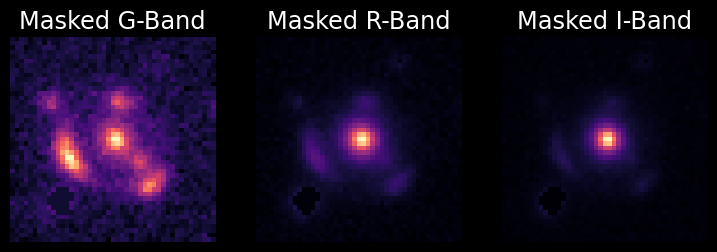

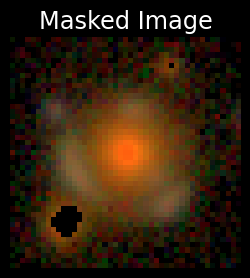

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


In [ ]:
start = time.perf_counter()
coadd_id = 1425127607

if(cluster):
    coadd_id = int(sys.argv[1])

model(10, coadd_id)
end = time.perf_counter()

print(f"Runtime: {(end - start)/60:.4f} minutes")
plt.close('all')